<a href="https://colab.research.google.com/github/Dmtrvna/MML/blob/main/%D0%9F%D1%80%D0%B0%D0%BA%D1%82%D0%B8%D0%BA%D0%B0-3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install pandas seaborn scikit-learn

# Домашнее задание 3

1. Выбрать номинальное значение как целевую переменную
2. Провести разведочный анализ **включая** анализ зависимости между номинальными переменными (chi2)
3. Выбрать `best_features`
4. Сделать нормализацию данных (scaler, onehotencoding)
4. Обучить модель логистической регрессии
5. Вывести метрики качества, описать полученный результат (также вывести коэфициенты модели)

In [94]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import chi2, SelectKBest
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report

In [65]:
df = pd.read_csv("/content/student_depression_dataset.csv")

# Удаление лишних столбцов
df = df.drop(columns=['id'])

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27901 entries, 0 to 27900
Data columns (total 17 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   Gender                                 27901 non-null  object 
 1   Age                                    27901 non-null  float64
 2   City                                   27901 non-null  object 
 3   Profession                             27901 non-null  object 
 4   Academic Pressure                      27901 non-null  float64
 5   Work Pressure                          27901 non-null  float64
 6   CGPA                                   27901 non-null  float64
 7   Study Satisfaction                     27901 non-null  float64
 8   Job Satisfaction                       27901 non-null  float64
 9   Sleep Duration                         27901 non-null  object 
 10  Dietary Habits                         27901 non-null  object 
 11  De

In [66]:
# Преобразование категориальных признаков в category
categorical = ["Gender", "City", "Profession", "Sleep Duration", "Dietary Habits",
               "Degree", "Have you ever had suicidal thoughts ?", "Financial Stress", "Family History of Mental Illness"]

for col in categorical:
    df[col] = df[col].astype('category')

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27901 entries, 0 to 27900
Data columns (total 17 columns):
 #   Column                                 Non-Null Count  Dtype   
---  ------                                 --------------  -----   
 0   Gender                                 27901 non-null  category
 1   Age                                    27901 non-null  float64 
 2   City                                   27901 non-null  category
 3   Profession                             27901 non-null  category
 4   Academic Pressure                      27901 non-null  float64 
 5   Work Pressure                          27901 non-null  float64 
 6   CGPA                                   27901 non-null  float64 
 7   Study Satisfaction                     27901 non-null  float64 
 8   Job Satisfaction                       27901 non-null  float64 
 9   Sleep Duration                         27901 non-null  category
 10  Dietary Habits                         27901 non-null  cat

Номинальные переменные (категориальные без порядка): 'Gender', 'City', 'Profession', 'Degree', 'Have you ever had suicidal thoughts ?', 'Family History of Mental Illness', 'Depression'

Порядковые переменные (категориальные с упорядоченной шкалой): 'Work Pressure', 'Academic Pressure', 'Study Satisfaction', 'Job Satisfaction', 'Dietary Habits', 'Sleep Duration', 'Financial Stress'

Числовые переменные: 'Age', 'CGPA',  'Work/Study Hours'

In [67]:
# y - целевая переменная, X - зависимые переменные
y = df['Depression']
X = df.drop('Depression', axis=1)

print('Размерность X:', X.shape)
print('Размерность y:', y.shape)

Размерность X: (27901, 16)
Размерность y: (27901,)


In [68]:
# Категориальные признаки
cat_cols = ['Gender', 'City', 'Profession', 'Degree', 'Family History of Mental Illness',
            'Have you ever had suicidal thoughts', 'Academic Pressure', 'Work Pressure', 'Study Satisfaction',
            'Job Satisfaction', 'Dietary Habits', 'Financial Stress', 'Sleep Duration']

# Числовые признаки
num_cols = ['Age', 'CGPA', 'Work/Study Hours']

## EDA

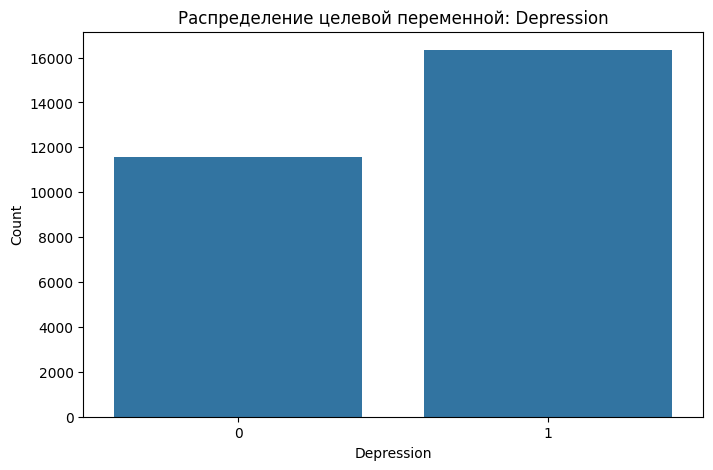


Процентное соотношение классов:
Depression
1    58.549873
0    41.450127
Name: proportion, dtype: float64


In [69]:
# Визуализация распределения целевой переменной
plt.figure(figsize=(8, 5))
sns.countplot(x=y)
plt.title('Распределение целевой переменной: Depression')
plt.xlabel('Depression')
plt.ylabel('Count')
plt.show()

# Процентное соотношение
print("\nПроцентное соотношение классов:")
print(y.value_counts(normalize=True) * 100)

В датасете явно преобладает наличие депрессии. Процент студентов с признаками депрессии значительно выше % студентов без депрессии.


ValueError: Could not interpret value `Have you ever had suicidal thoughts` for `x`. An entry with this name does not appear in `data`.

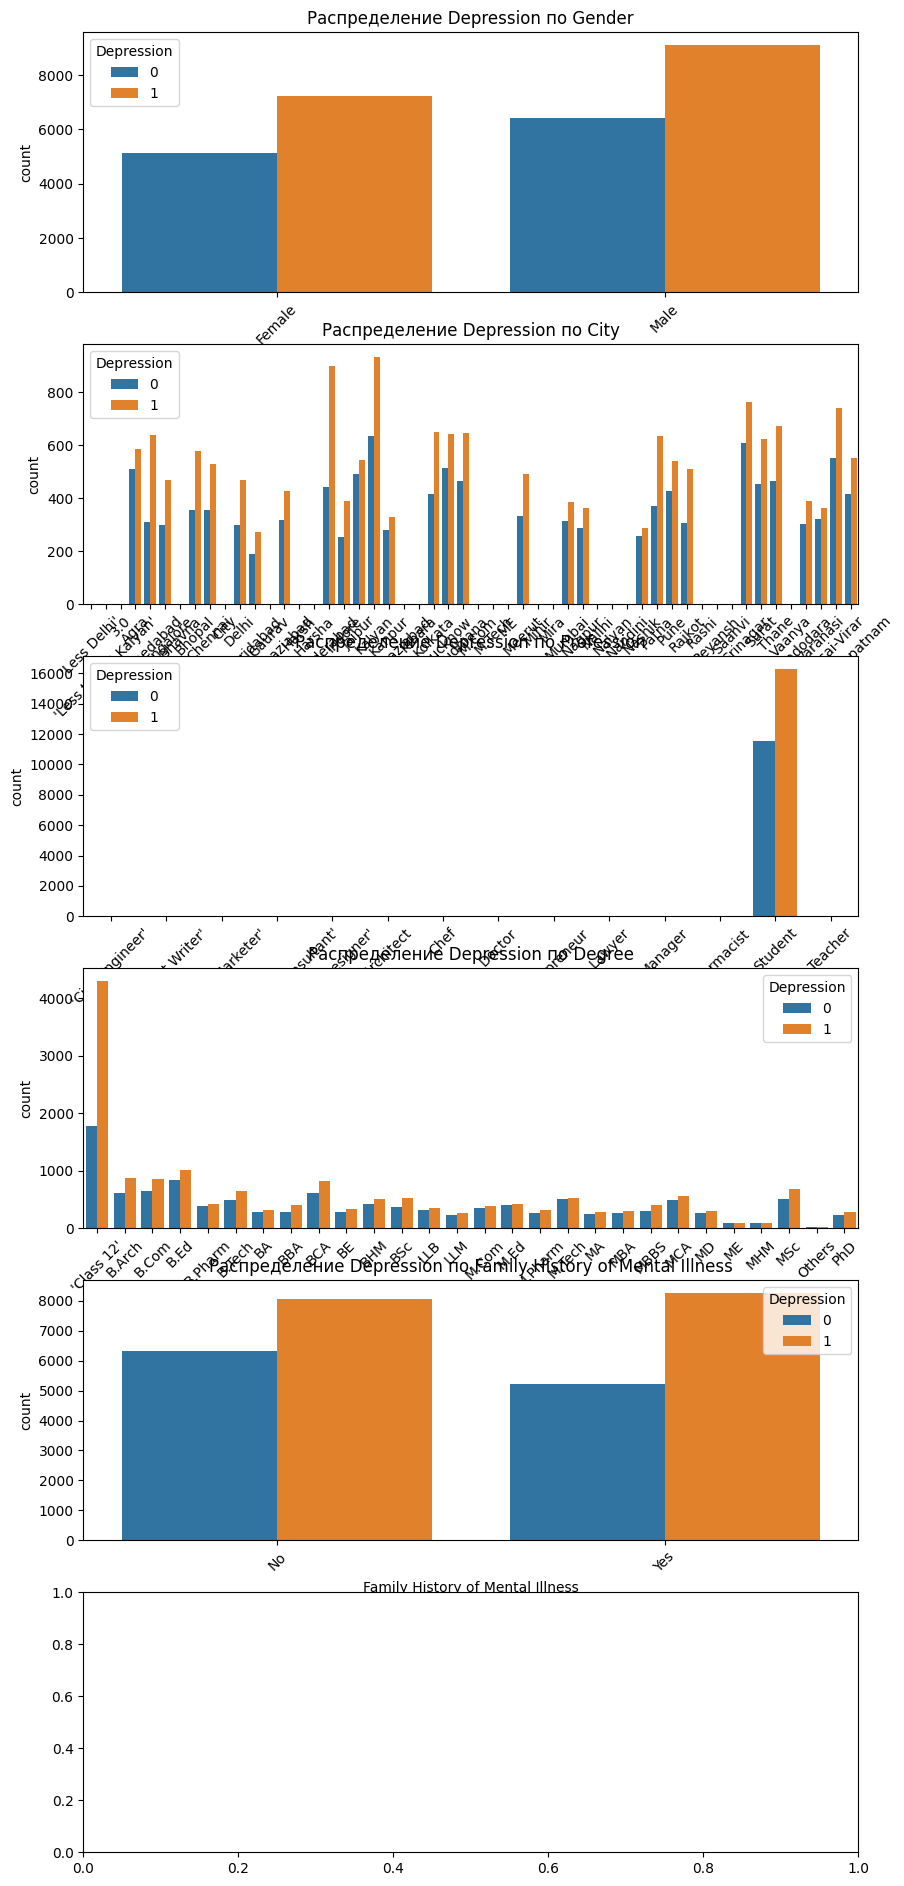

In [70]:
# Выделяем только номинальные признаки для анализа
nominal_cols = ['Gender', 'City', 'Profession', 'Degree', 'Family History of Mental Illness', 'Have you ever had suicidal thoughts ?']

# Pаспределения целевой переменной по номинальным признакам
plt.figure(figsize=(10, len(cat_cols)*4))

for i, col in enumerate(cat_cols, 1):
    plt.subplot(len(cat_cols), 1, i)
    sns.countplot(x=col, hue='Depression', data=df)
    plt.title(f"Распределение Depression по {col}")
    plt.xticks(rotation=45)

plt.tight_layout()
plt.show()


Анализ номинальных признаков относительно целевой переменной Depression показал:

1. Gender. Из графика видно, что среди студентов доля людей с депрессией превышает долю без депрессии в обеих группах. Это говорит о высокой распространенности депрессии как среди мужчин, так и женщин практически в равной мере. Таким образом пол не влияет на депрессию.

2. City. В отдельных городах депрессия встречается значительно чаще, в других городах различия есть, но не очень выраженные. Таким образом город слабо влияет на депрессию.

3. Profession. На графике мы видим явное распределение депрессии только у студентов. По другим категориям распределения практически нет из-за малого числа данных. Предполагается, что данный признак не подходит для дальнейших исследований.

4. Degree. Наиболее выраженное различие по депрессии наблюдается среди студентов младших классов (Class 2-12). На других уровнях образования разницы в долях людей с депрессией и без неё и между уровнями практически нет. Предполагается, что данный признак не подходит для дальнейших исследований.

5. Family History of Mental Illness. В семьях с историей психических расстройств депрессия встречается чаще. Признак имеет заметную связь с депрессией.

6. Suicidal thoughts. Студенты с суицидальными мыслями гораздо чаще имеют депрессию по сравнению людьми без таких мыслей. Таким образом суицидальные мысли напрямую влияют на депрессию.

Анализ зависимости между номинальными переменными (chi2)

In [71]:
X_cat = df[nominal_cols].copy()
X_cat = pd.get_dummies(X_cat)
le = LabelEncoder()
y_cat = le.fit_transform(df['Depression'])

chi2_scores, p_values = chi2(X_cat, y_cat)
chi2_res = pd.DataFrame({'feature': X_cat.columns, 'chi2': chi2_scores, 'p_val': p_values})
chi2_res = chi2_res.sort_values(by='p_val')
chi2_res.head(20)

,feature,chi2,p_val
99,Have you ever had suicidal thoughts ?_Yes,3057.294614,0.000000e+00
98,Have you ever had suicidal thoughts ?_No,5268.872006,0.000000e+00
68,Degree_'Class 12',374.298676,2.168970e-83
97,Family History of Mental Illness_Yes,41.103170,1.444020e-10
18,City_Hyderabad,38.870576,4.528554e-10
96,Family History of Mental Illness_No,38.548139,5.341969e-10
6,City_Ahmedabad,29.985916,4.351958e-08
85,Degree_M.Tech,24.140783,8.954369e-07
83,Degree_M.Ed,21.660200,3.254747e-06
20,City_Jaipur,16.076227,6.084305e-05


Метрика Chi2 показывает, насколько сильно каждый из признаков связан с целевой переменной.

* chi2_scores (χ²): чем выше значение, тем сильнее статистическая связь между соответствующим признаком и целевой переменной.

* p_values (p-значение): чем ниже значение, тем менее вероятно, что обнаруженная связь случайна. Общепринятый порог значимости — 0.05. Если p-value ниже этого порога, признак считается статистически значимым.​

**Самая сильная связь с депрессией:**

Have you ever had suicidal thoughts ?_Yes

Have you ever had suicidal thoughts ?_No

Это значит, что наличие или отсутвие суицидальных мыслей имеют максимальную статистически значимую связь с депрессией.


### Отбор признаков


Дополнительно используем класс SelectKBest для сравнения наиболее значимых признаков согласно chi2.

In [72]:
# Категориальные + числовые признаки
feature_cols = nominal_cols + num_cols

X = df[feature_cols]
X_ohe = pd.get_dummies(X)
y = le.transform(df['Depression'])

# Отбор 20 лучших признаков
selector = SelectKBest(chi2, k=20)
selector.fit(X_ohe, y)

best_features_mask = selector.get_support()
best_features = X_ohe.columns[best_features_mask]
print(best_features)

Index(['Age', 'Work/Study Hours', 'City_Agra', 'City_Ahmedabad',
       'City_Hyderabad', 'City_Jaipur', 'City_Patna', 'Degree_'Class 12'',
       'Degree_B.Ed', 'Degree_B.Pharm', 'Degree_LLB', 'Degree_M.Com',
       'Degree_M.Ed', 'Degree_M.Tech', 'Degree_MCA', 'Degree_MD',
       'Family History of Mental Illness_No',
       'Family History of Mental Illness_Yes',
       'Have you ever had suicidal thoughts ?_No',
       'Have you ever had suicidal thoughts ?_Yes'],
      dtype='object')


In [73]:
best_features = ['Age', 'Work/Study Hours', 'City', 'Degree',
                 'Family History of Mental Illness', 'Have you ever had suicidal thoughts ?']

## Нормализация и кодирование категорий

In [78]:
# Используем только best_features для X
X_selected = best_features

# В best_features есть числовые признаки — нормализуем
numeric = ['Age', 'Work/Study Hours']
scaler = StandardScaler()
df[numeric] = scaler.fit_transform(df[numeric])

y = le.transform(df['Depression'])

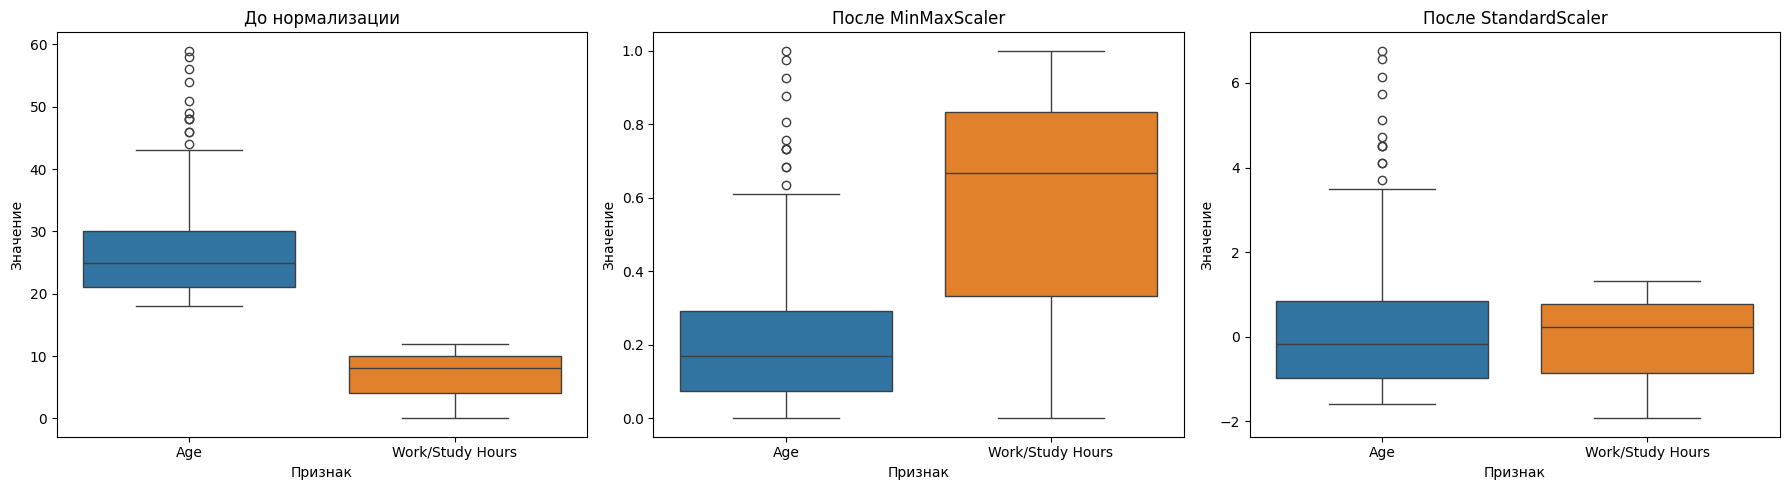

In [103]:
from sklearn.preprocessing import MinMaxScaler

df_orig = pd.read_csv("/content/student_depression_dataset.csv")

categorical = ["Gender", "City", "Profession", "Sleep Duration", "Dietary Habits",
               "Degree", "Have you ever had suicidal thoughts ?", "Financial Stress", "Family History of Mental Illness"]
for col in categorical:
    df[col] = df[col].astype('category')

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# 1. До нормализации
sns.boxplot(data=df_orig[numeric], ax=axes[0])
axes[0].set_title('До нормализации')
axes[0].set_xlabel('Признак')
axes[0].set_ylabel('Значение')

# 2. После MinMaxScaler
scaler_mm = MinMaxScaler()
X_mm = pd.DataFrame(scaler_mm.fit_transform(df[numeric]), columns=numeric)
sns.boxplot(data=X_mm, ax=axes[1])
axes[1].set_title('После MinMaxScaler')
axes[1].set_xlabel('Признак')
axes[1].set_ylabel('Значение')

# 3. После StandardScaler
scaler_std = StandardScaler()
X_std = pd.DataFrame(scaler_std.fit_transform(df[numeric]), columns=numeric)
sns.boxplot(data=X_std, ax=axes[2])
axes[2].set_title('После StandardScaler')
axes[2].set_xlabel('Признак')
axes[2].set_ylabel('Значение')

plt.tight_layout()
plt.show()

До нормализации:

* Распределения исходных признаков имеют различные масштабы (Age достигает 60, Work/Study Hours — около 15), что может негативно влиять на обучение модели из-за дисбаланса масштабов.

* Присутствуют выбросы.

После MinMaxScaler:

* Все значения теперь находятся в диапазоне.

* Выбросы также масштабированы в этот же диапазон.

После StandardScaler:

* Распределения нормированы: среднее близко к 0, стандартное отклонение близко к 1.

* Выбросы все ещё есть.

* Шкала становится симметричной относительно центра.

In [104]:
# Kодирование категорий (onehotencoding)
numeric = ['Age', 'Work/Study Hours']
nominal_cols = ['City', 'Degree', 'Family History of Mental Illness', 'Have you ever had suicidal thoughts ?']
best_features = nominal_cols + numeric

X_selected = df_orig[best_features].copy()

X_ohe = pd.get_dummies(X, columns=nominal_cols)

X = df[best_features]  # или свой список нужных признаков
X_encoded = pd.get_dummies(X, columns=nominal_cols)

## Model

In [92]:
from sklearn.linear_model import LogisticRegression

In [106]:
y = df['Depression']

In [108]:
from sklearn.model_selection import train_test_split

# Разделяем данные
X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, y, test_size=0.3, random_state=42, stratify=y
) # stratify - разделение данных с учетом распределнеия категориальной переменной

In [110]:
# Обучаем модель
model = LogisticRegression(max_iter=10000)
model.fit(X_train, y_train)

LogisticRegression(max_iter=10000)

### Метрики качества

In [112]:
# Предсказание
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)

1. accuracy_score — точность классификации. Показывает долю правильных предсказаний (класс попал в истинную категорию). Чем ближе к 1 (или 100%), тем лучше.

2. precision_score — точность положительного класса (Precision). Из всех объектов, которые модель предсказала как положительные, какой процент оказался истинно положительным. Важно минимизировать ложноположительные ошибки.

3. recall_score — полнота (Recall). Из всех истинно положительных примеров, какая доля была правильно найдена моделью. Важно минимизировать ложноотрицательные ошибки.

4. f1_score — гармоническое среднее между Precision и Recall. Используется, когда нужно сбалансировать точность и полноту.

5. roc_auc_score — площадь под ROC кривой (AUC). Чем выше значение, тем лучше модель разделяет классы. Значение от 0.5 (случайная модель) до 1 (идеальная модель).

6. confusion_matrix — матрица ошибок. Помогает понять, где и сколько ошибок модель допускает. Показывает количество:
* истинно положительных (TP),
* истинно отрицательных (TN),
* ложноположительных (FP),
* ложноотрицательных (FN) предсказаний.

In [117]:
def evaluate_classification(y_true, y_pred, y_proba=None):
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, average='weighted', zero_division=0)
    rec = recall_score(y_true, y_pred, average='weighted', zero_division=0)
    f1 = f1_score(y_true, y_pred, average='weighted', zero_division=0)

    roc_auc = None
    if y_proba is not None:
        classes = np.unique(y_true)
        y_true_onehot = np.eye(len(classes))[np.searchsorted(classes, y_true)]
        roc_auc = roc_auc_score(y_true_onehot, y_proba, multi_class='ovr')

    cm = confusion_matrix(y_true, y_pred)

    print("=== Метрики классификации ===")
    print(f"Accuracy:  {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall:    {rec:.4f}")
    print(f"F1-score:  {f1:.4f}")
    if roc_auc is not None:
        print(f"ROC-AUC:   {roc_auc:.4f}")
    print("\nConfusion Matrix:")
    print(f"TN: {cm[0,0]}   FN: {cm[0,1]}\nFP: {cm[1,0]}   TP: {cm[1,1]}")

    return {"accuracy": acc, "precision": prec, "recall": rec, "f1": f1, "roc_auc": roc_auc, "confusion_matrix": cm}

metrics = evaluate_classification(y_test, y_pred, y_proba)

=== Метрики классификации ===
Accuracy:  0.7876
Precision: 0.7865
Recall:    0.7876
F1-score:  0.7856
ROC-AUC:   0.8388

Confusion Matrix:
TN: 2404   FN: 1066
FP: 712   TP: 4189


1. Accuracy - 0.7876. Модель правильно предсказывает примерно 78% всех случаев. Это указывает на довольно высокую точность работы модели.

2. Precision - 0.7865. Из всех случаев, которые модель предсказала как положительные, около 78% действительно являются положительными. Видим низкое количество ложноположительных ошибок.

3. Recall - 0.7876. Из всех положительных случаев модель обнаруживает примерно 78%, то есть хорошо находит большую часть позитивных образцов. Видим низкое количество ложноотрицательных ошибок.

4. F1-score - 0.7856. О тражает баланс между точностью и полнотой. Значение около 0.79 указывает на высокую точность и полноту предсказаний модели.

5. ROC-AUC - 0.8388. Площадь под ROC-кривой указывает, что модель хорошо различает классы. 83% вероятности указывает на то, что модель правильно отсортирует случайный положительный пример выше случайного отрицательного.

6. Матрица ошибок:

* TN = 2404 - число правильно распознанных отрицательных случаев;
* FN = 1066 - число пропущенных положительных случаев (ошибочно классифицированы как отрицательные);
* FP = 712 - число ошибочно классифицированных отрицательных случаев как положительные;
* TP = 4189 - число правильно распознанных положительных случаев.

Модель показала сбалансированные и довольно точные предсказания (с точностью около 79%). Отношение FP к FN показывает, что модель чуть чаще пропускает положительные случаи, чем ошибочно классифицирует отрицательные как положительные. Высокий ROC-AUC подтверждает, что модель эффективно разделяет классы.

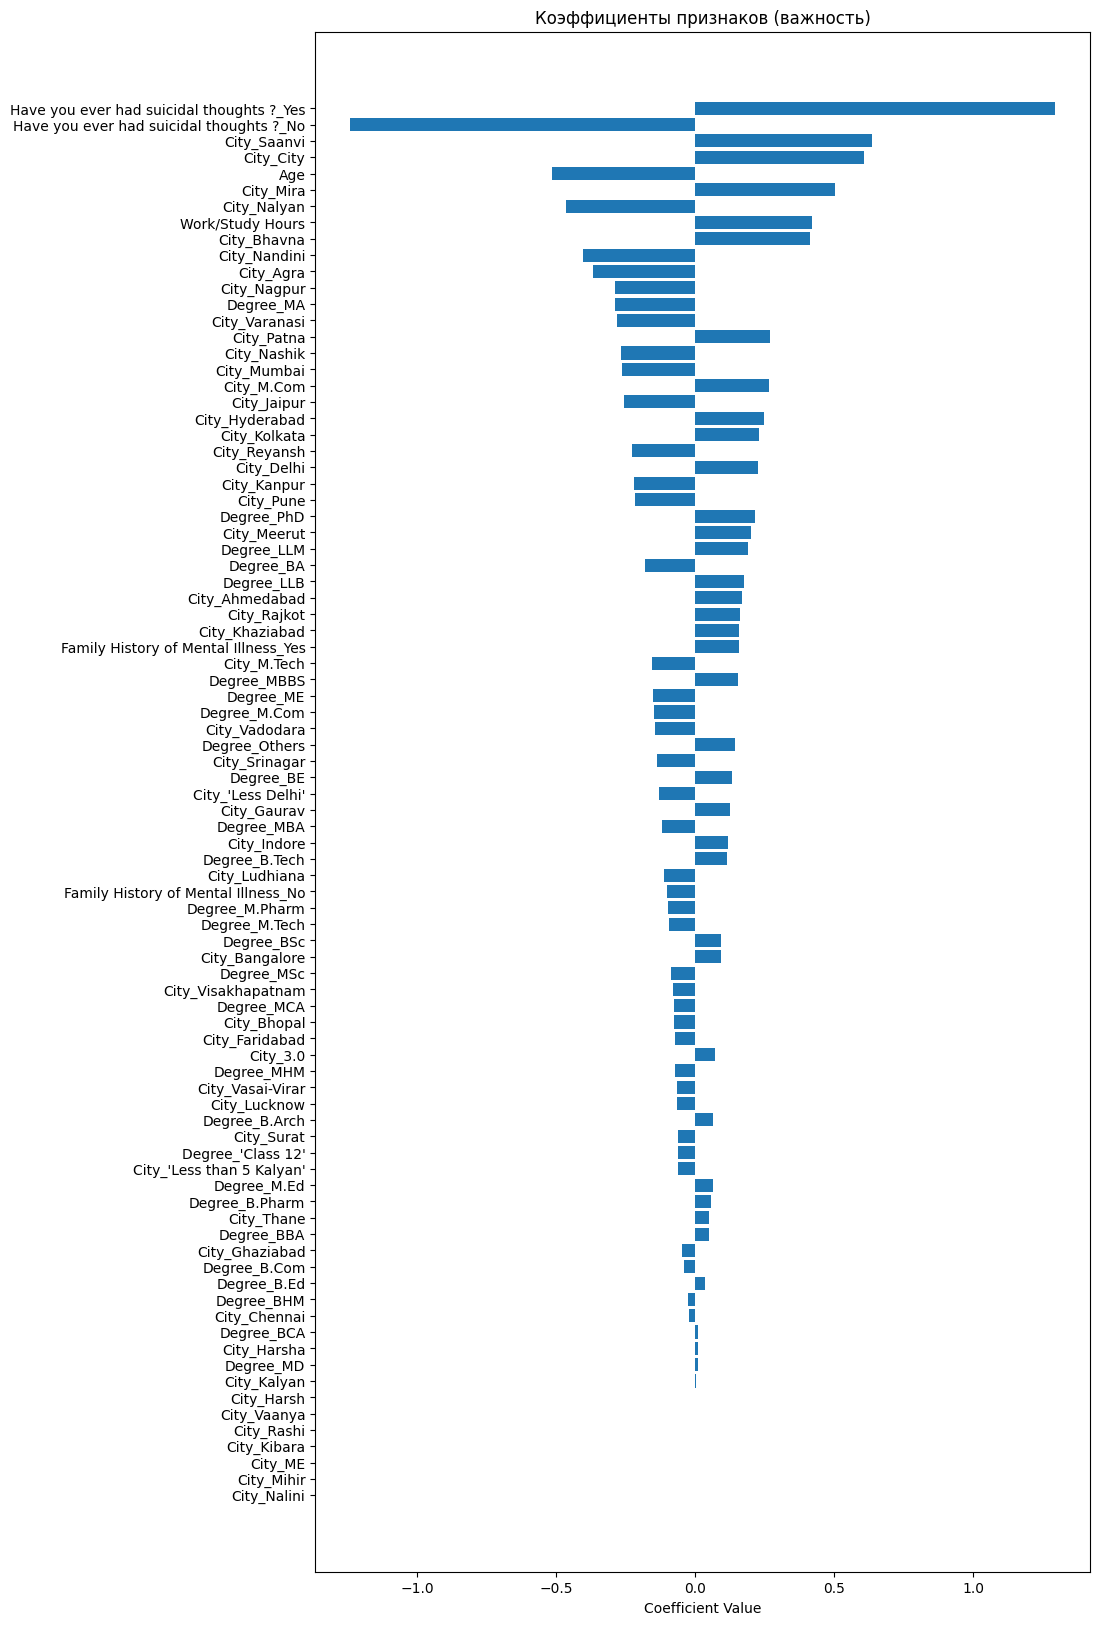

In [121]:
# График коэффициентов
coef_1d = model.coef_.ravel()  # или model.coef_[0]
coef_df = pd.DataFrame({'Feature': X_train.columns, 'Coefficient': coef_1d})
coef_df = coef_df.reindex(coef_df['Coefficient'].abs().sort_values(ascending=False).index)

plt.figure(figsize=(10, 20))
plt.barh(coef_df['Feature'], coef_df['Coefficient'])
plt.xlabel('Coefficient Value')
plt.title('Коэффициенты признаков (важность)')
plt.gca().invert_yaxis()
plt.show()
